# Exploratory data analysis of TMED2 dataset
For details of the dataset from official provider, please refer to https://tmed.cs.tufts.edu/#dataset

In [1]:
import glob
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
source_f = 'D:\\Datasets\\TMED2\\approved_users_only\\'

unl_f = source_f + 'unlabeled_set\\'
view_and_diagnosis_folder = source_f +  'view_and_diagnosis_labeled_set\\'
view_folder = source_f +  'view_labeled_set\\'

vd_l_f = view_and_diagnosis_folder + 'labeled\\'
vd_unl_f = view_and_diagnosis_folder + 'unlabeled\\'
v_l_f = view_folder + 'labeled\\'
v_unl_f = view_folder + 'unlabeled\\'


In [2]:
# check if the number of files is consistent with the excel spreadsheets provided and online information
def get_folder_pngs(folder_path):
    pngs = glob.glob(folder_path + '**\\*.png', recursive=True)
    print('number of images in ' + folder_path + ': ' + str(len(pngs)))
    return pngs

unl_pngs = get_folder_pngs(unl_f)
vd_l_pngs = get_folder_pngs(vd_l_f)
vd_unl_pngs = get_folder_pngs(vd_unl_f)
v_l_pngs = get_folder_pngs(v_l_f)
v_unl_pngs = get_folder_pngs(v_unl_f)


number of images in D:\Datasets\TMED2\approved_users_only\unlabeled_set\: 353500
number of images in D:\Datasets\TMED2\approved_users_only\view_and_diagnosis_labeled_set\labeled\: 17270
number of images in D:\Datasets\TMED2\approved_users_only\view_and_diagnosis_labeled_set\unlabeled\: 26590
number of images in D:\Datasets\TMED2\approved_users_only\view_labeled_set\labeled\: 7694
number of images in D:\Datasets\TMED2\approved_users_only\view_labeled_set\unlabeled\: 37576


In [3]:
# check the labelled excel sheet
def get_patient_id(text):
    # remove everything after 's'
    ind = text.find('s')
    return text[:ind]
df = pd.read_csv(source_f + 'labels_per_image.csv')
df['patient_id'] = df['query_key'].map(get_patient_id)

In [4]:
df_vd_l = df[df['diagnosis_label']!='Not_Provided'].copy()
df_vd_l['path'] = df_vd_l['query_key'].map(lambda x: vd_l_f + x)
vd_patients = df_vd_l['patient_id'].unique()
print('VD labelled images: {0}, patients: {1}'.format(len(df_vd_l), len(vd_patients)))
df_v_l = df[df['diagnosis_label']=='Not_Provided'].copy()
df_v_l['path'] = df_v_l['query_key'].map(lambda x: v_l_f + x)
v_patients = df_v_l['patient_id'].unique()
print('V labelled images: {0}, patients: {1}'.format(len(df_v_l), len(v_patients)))

VD labelled images: 17270, patients: 576
V labelled images: 7694, patients: 703


This matches up with the folder. According to website we are missing one patient in VD_labelled

In [5]:
df_unl = pd.read_csv(source_f + 'TMED2_train_unlabeled.csv')
df_unl['path'] = df_unl['query_key'].map(lambda x: unl_f + x)
df_unl['patient_id'] = df_unl['query_key'].map(get_patient_id)
unl_patients = df_unl['patient_id'].unique()
print('UNlabelled images: {0}, patients: {1}'.format(len(df_unl), len(unl_patients)))

UNlabelled images: 353500, patients: 5119


This matches up with the folder. Website says there should be 5287 patients

In [6]:
# check the label distributions in each dataset - image level
print(df_v_l['view_label'].value_counts())
#print(df_vd_l['view_label'].value_counts())
#print(df_vd_l['diagnosis_label'].value_counts())
pd.crosstab(df_vd_l['view_label'], df_vd_l['diagnosis_label'])

PLAX    2564
A4C     2359
A2C     1766
PSAX    1005
Name: view_label, dtype: int64


diagnosis_label,mild_AS,mildtomod_AS,moderate_AS,no_AS,severe_AS
view_label,,,,,
A2C,409,77,530,124,530
A4C,531,103,700,177,695
A4CorA2CorOther,0,0,2765,0,4096
PLAX,474,209,1483,1077,1565
PSAX,261,63,427,304,670


Caveat: The A4CorA2CorOther category only exists in the VD section

In [7]:
# check the label distribution at the patient-level
severities = []
inconsistency = []
for ind, p in enumerate(vd_patients):
    dfp = df_vd_l[df_vd_l['patient_id']==p]
    if (dfp['diagnosis_label'] == dfp.iloc[0]['diagnosis_label']).all():
        severities.append(dfp.iloc[0]['diagnosis_label'])
    else:
        severities.append(dfp.iloc[0]['diagnosis_label'])
        inconsistency.append(p)
print(pd.Series(severities).value_counts())
print(inconsistency) # which patients have multiple AS labels across multiple exams

severe_AS       164
mild_AS         138
no_AS           125
moderate_AS     122
mildtomod_AS     27
dtype: int64
['3521', '3190', '6080', '6184', '4226']


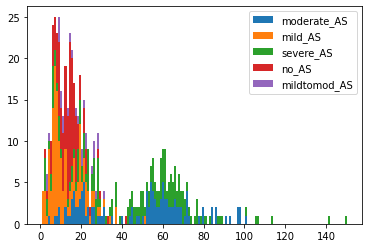

In [8]:
# amount of videos per severity-labelled patient - All images

# create a separate view for each severity
sev = df_vd_l['diagnosis_label'].unique()
df_vd_l_severity = {}
pvc = {}
for s in sev:
    df_vd_l_severity[s] = df_vd_l[df_vd_l['diagnosis_label']==s]
# determine the number of videos per patient for each severity
pvc = [list(df_vd_l_severity[s]['patient_id'].value_counts()) for s in sev]
pvc_max = max(df_vd_l['patient_id'].value_counts())
plt.hist(pvc, bins=pvc_max, label=sev, stacked=True)
plt.legend()

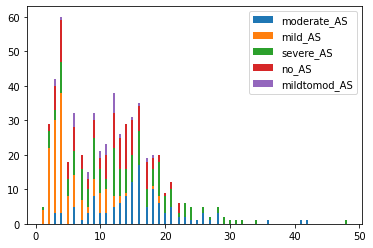

In [9]:
# amount of videos per severity-labelled patient - PLAX/PSAX only

# create a separate view for each severity
sev = df_vd_l['diagnosis_label'].unique()
df_vd_l_severity = {}
pvc = {}
for s in sev:
    by_sev = df_vd_l[df_vd_l['diagnosis_label']==s]
    df_vd_l_severity[s] = by_sev[by_sev['view_label'].isin(['PLAX','PSAX'])]
# determine the number of videos per patient for each severity
pvc = [list(df_vd_l_severity[s]['patient_id'].value_counts()) for s in sev]
pvc_max = max(df_vd_l['patient_id'].value_counts())
plt.hist(pvc, bins=pvc_max, label=sev, stacked=True)
plt.legend()

In [10]:
# average number of images for each severity
sev = df_vd_l['diagnosis_label'].unique()
for s in sev:
    nimages = []
    # get a list of patients with that degree of severity
    s_patients = df_vd_l[df_vd_l['diagnosis_label']==s]['patient_id'].unique()
    for p in s_patients: # count the number of images
        n_images = len(df[df['patient_id']==p])
        nimages.append(n_images)
    n_avg = np.median(nimages)
    n_stdev = np.std(nimages)
    print('For class {0}, median images: {1}, std:{2}'.format(s, n_avg, n_stdev))

For class moderate_AS, median images: 55.0, std:25.063610000071943
For class mild_AS, median images: 9.0, std:11.869052308252813
For class severe_AS, median images: 49.0, std:27.66830026044448
For class no_AS, median images: 14.0, std:6.9073132258498315
For class mildtomod_AS, median images: 17.0, std:12.284465526772568


In [11]:
# are the "unl" sections in labelled folders subsets of the wider unlabelled set?
print(len(unl_pngs))
print(len(vd_unl_pngs))
print(len(v_unl_pngs))

unl_patients = set([get_patient_id(x) for x in unl_pngs])
vd_unl_patients = set([get_patient_id(x) for x in vd_unl_pngs])
v_unl_patients = set([get_patient_id(x) for x in v_unl_pngs])

print(vd_unl_patients.difference(unl_patients)) # if set empty, indicates vd_unl is a subset of unl
print(v_unl_patients.difference(unl_patients))

353500
26590
37576
set()
set()


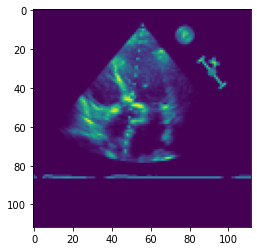

In [12]:
# try opening an image
list_of_ambiguous_views = list(df_vd_l[df_vd_l['view_label']=='A4CorA2CorOther']['path'])
plt.imshow(plt.imread(list_of_ambiguous_views[78]))

In [13]:
df_vd_l

,query_key,view_label,diagnosis_label,patient_id,path
0,4860s1_0.png,A4C,moderate_AS,4860,D:\Datasets\TMED2\approved_users_only\view_and...
1,4860s1_1.png,A2C,moderate_AS,4860,D:\Datasets\TMED2\approved_users_only\view_and...
2,4860s1_2.png,PLAX,moderate_AS,4860,D:\Datasets\TMED2\approved_users_only\view_and...
3,4860s1_3.png,PLAX,moderate_AS,4860,D:\Datasets\TMED2\approved_users_only\view_and...
4,4860s1_4.png,PLAX,moderate_AS,4860,D:\Datasets\TMED2\approved_users_only\view_and...
...,...,...,...,...,...
17265,5897s1_16.png,A2C,severe_AS,5897,D:\Datasets\TMED2\approved_users_only\view_and...
17266,5897s1_17.png,A2C,severe_AS,5897,D:\Datasets\TMED2\approved_users_only\view_and...
17267,5897s1_18.png,A2C,severe_AS,5897,D:\Datasets\TMED2\approved_users_only\view_and...
17268,5897s1_19.png,A4C,severe_AS,5897,D:\Datasets\TMED2\approved_users_only\view_and...


In [14]:
# check the population of the DEV479 splits (479 refers to 360 tr, 119 val, 119 test studies) (598 in total)
# for reference, TMED2 website states there are 599 studies in total
def get_study_id(text):
    # remove everything after 's'
    ind = text.find('_')
    return text[:ind]

def read_dev_fold_csv(filepath):
    fold = pd.read_csv(filepath)
    fold['study'] = fold['query_key'].map(get_study_id)
    splits = ['train', 'val', 'test']
    fold_splits = {}
    for s in splits:
        fold_splits[s] = fold[fold['diagnosis_classifier_split']==s]
        print(len(list(fold_splits[s]['study'].value_counts())))
    return fold_splits, fold
s0f, s0 = read_dev_fold_csv(source_f + 'DEV479\\TMED2_fold0_labeledpart.csv')
s1f, s1 = read_dev_fold_csv(source_f + 'DEV479\\TMED2_fold1_labeledpart.csv')
s2f, s2 = read_dev_fold_csv(source_f + 'DEV479\\TMED2_fold2_labeledpart.csv')

360
119
119
360
119
119
360
118
120


In [15]:
# see if each set is using the same group of studies
print(sorted(s0['study'].unique()) == sorted(s1['study'].unique())) # true
print(sorted(s0['study'].unique()) == sorted(s2['study'].unique())) # true
# see if the training splits of each set intersect
print(len(s0f['train']['study'].unique()))
print(len(s1f['train']['study'].unique()))
print(len(set(s2f['test']['study'].unique()).intersection(set(s0f['test']['study'].unique()))))

True
True
360
360
37


In [16]:
# look at how many images are in each study, bin them appropriately
bin_vals = [0, 2, 4, 8, 16, 32, 64, 128]
bins = [[] for i in range(len(bin_vals)-1)]
for i in list(s0f['val']['study'].value_counts()):
    for j in range(len(bin_vals)-1):
        if i > bin_vals[j] and i <= bin_vals[j+1]:
            bins[j].append(i)
for k in bins:
    print(len(k))

5
1
16
32
22
29
14


In [20]:
# look at the class distribution of the training set
diagnosis_label = []
for s in s0f['train']['study'].unique():
    study = s0f['train'][s0f['train']['study']==s]
    diagnosis_label.append(study.iloc[0]['diagnosis_label'])
from collections import Counter
c = Counter(diagnosis_label)
print(c)

Counter({'severe_AS': 99, 'mild_AS': 87, 'moderate_AS': 82, 'no_AS': 76, 'mildtomod_AS': 16})
